# ATC - price At The Close - Analytics

### Import Library

In [29]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 9]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2025-02-14 14:15:00,1343.0,1343.0,1340.3,1341.3,7141
2025-02-14 14:20:00,1340.9,1341.9,1340.5,1341.4,4593
2025-02-14 14:25:00,1341.1,1342.5,1340.7,1342.5,4207


In [21]:
def get_data_11h25(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1125]
  if not tick.empty:
    return tick[0]
      
def get_data_13h00(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1300]
  if not tick.empty:
    return tick[0]

def get_data_14h25(tick):
  tick = tick[100*tick.index.hour+tick.index.minute == 1425]
  if not tick.empty:
    return tick[0]

def get_max_price_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute >= 900]
  tick = tick[100*tick.index.hour+tick.index.minute <= 1130]
  return tick.max()

def get_min_price_morning(tick):
  tick = tick[100*tick.index.hour+tick.index.minute >= 900]
  tick = tick[100*tick.index.hour+tick.index.minute <= 1130]
  return tick.min()

def get_max_price_affternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute >= 1300]
  tick = tick[100*tick.index.hour+tick.index.minute <= 1425]
  return tick.max()

def get_min_price_affternoon(tick):
  tick = tick[100*tick.index.hour+tick.index.minute >= 1300]
  tick = tick[100*tick.index.hour+tick.index.minute <= 1425]
  return tick.min()

In [22]:
day_data = data.copy()
day_data['close_11h25'] = day_data['Close']
day_data['open_13h00'] = day_data['Open']
day_data['close_14h25'] = day_data['Close']
day_data['morning_high'] = day_data['High']
day_data['morning_low'] = day_data['Low']
day_data['affternoon_high'] = day_data['High']
day_data['affternoon_low'] = day_data['Low']
day_data['RSI'] = ta.rsi(day_data["Close"], length=14)
day_data['RSI_14h25'] = day_data['RSI']
day_data = day_data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'morning_high': get_max_price_morning,
        'morning_low': get_min_price_morning,
        'affternoon_high': get_max_price_affternoon,
        'affternoon_low': get_min_price_affternoon,
        'close_11h25': get_data_11h25,
        'open_13h00': get_data_13h00,
        'close_14h25': get_data_14h25,
        'RSI_14h25': get_data_14h25
    })
day_data.dropna(subset=['Close'], inplace=True)

In [23]:
day_data['return'] = day_data['Close'] - day_data['close_14h25']

In [24]:
day_data['morning_ibs'] = day_data.apply(lambda x: (0 if (x["morning_high"] == x["morning_low"]) else (x["close_11h25"] - x["morning_low"]) / (x["morning_high"] - x["morning_low"])), axis=1)
day_data['morning_ibs'] = round(day_data['morning_ibs'], 2)
day_data['afternoon_ibs'] = day_data.apply(lambda x: (0 if (x["affternoon_high"] == x["affternoon_low"]) else (x["close_14h25"] - x["affternoon_low"]) / (x["affternoon_high"] - x["affternoon_low"])), axis=1)
day_data['afternoon_ibs'] = round(day_data['afternoon_ibs'], 2)

In [25]:
day_data['morning_ibs_group'] = pd.qcut(day_data['morning_ibs'], 20)
day_data['afternoon_ibs_group'] = pd.qcut(day_data['afternoon_ibs'], 20)

In [30]:
day_data['RSI_14h25'] = round(day_data['RSI_14h25'])

In [26]:
day_data

,Open,Close,morning_high,morning_low,affternoon_high,affternoon_low,close_11h25,open_13h00,close_14h25,RSI_14h25,return,morning_ibs,afternoon_ibs,morning_ibs_group,afternoon_ibs_group
Date,,,,,,,,,,,,,,,
2018-08-13,943.5,954.2,947.3,942.3,954.6,946.7,947.0,947.5,954.1,77.679789,0.1,0.94,0.94,"(0.91, 0.96]","(0.92, 0.95]"
2018-08-14,955.5,959.3,957.3,952.1,961.8,952.5,954.5,954.5,960.1,65.400887,-0.8,0.46,0.82,"(0.43, 0.48]","(0.78, 0.84]"
2018-08-15,958.0,946.6,962.3,956.0,959.9,949.9,958.2,957.7,951.2,30.636916,-4.6,0.35,0.13,"(0.33, 0.38]","(0.12, 0.18]"
2018-08-16,942.4,947.0,943.5,935.5,947.3,936.5,938.1,938.5,944.5,59.729975,2.5,0.33,0.74,"(0.28, 0.33]","(0.72, 0.78]"
2018-08-17,952.2,947.0,954.6,948.5,954.4,945.0,954.0,954.3,947.0,39.751862,0.0,0.90,0.21,"(0.87, 0.91]","(0.18, 0.23]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10,1333.4,1330.5,1335.0,1325.2,1337.6,1330.0,1333.1,1332.9,1330.0,36.002825,0.5,0.81,0.00,"(0.77, 0.82]","(-0.001, 0.03]"
2025-02-11,1332.5,1334.1,1334.0,1327.6,1333.0,1328.9,1330.8,1330.8,1332.4,57.098407,1.7,0.50,0.85,"(0.48, 0.54]","(0.84, 0.88]"
2025-02-12,1337.4,1329.5,1342.0,1337.4,1340.7,1332.8,1339.7,1339.8,1332.8,20.430799,-3.3,0.50,0.00,"(0.48, 0.54]","(-0.001, 0.03]"


## Max Long-Short profitable (at 100% winrate)

In [44]:
# Long
long_data = day_data[day_data['return'] > 0]
# Short
short_data = day_data[day_data['return'] < 0]

In [46]:
long_data['return'].sum()

1708.1

In [47]:
short_data['return'].sum()

-1641.4000000000024

## Analytics

In [33]:
analytics_data = day_data[(day_data.index > '2020-11-01 00:00:00') & (day_data.index < '2024-10-01 00:00:00')]

### Analytic by RSI at 14h30

<Axes: xlabel='RSI_14h25'>

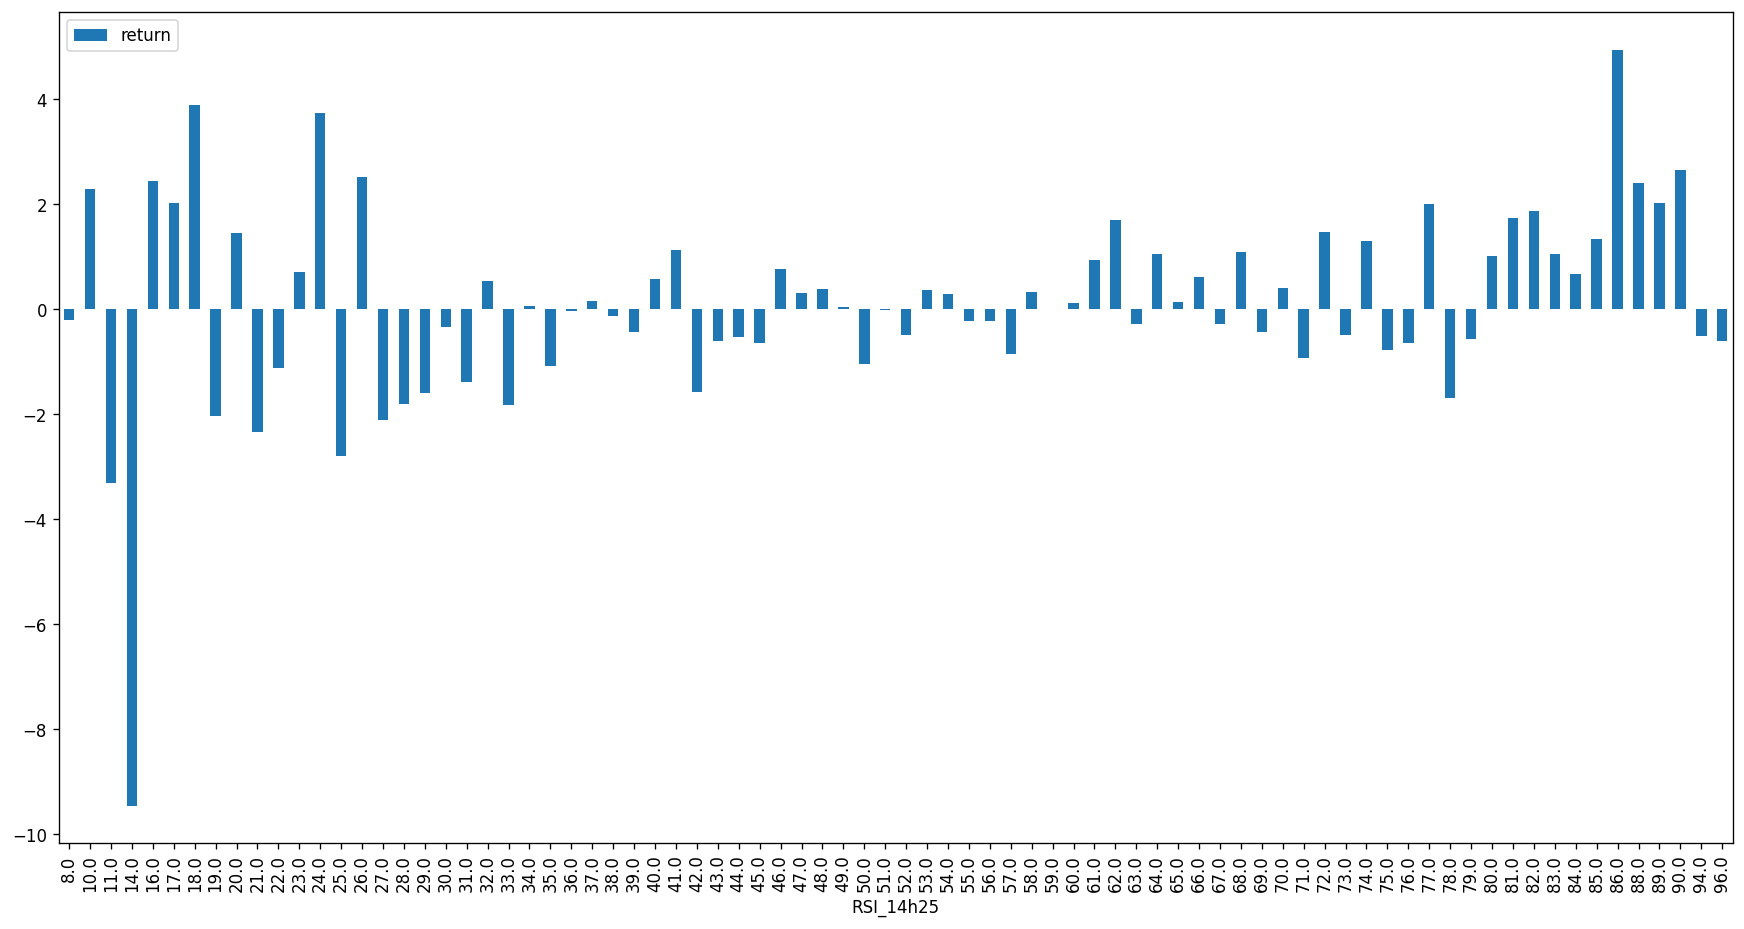

In [34]:
day_data_grouped_by_rsi = analytics_data.groupby(['RSI_14h25'])[['return']].mean()
day_data_grouped_by_rsi.plot.bar()

<Axes: xlabel='RSI_14h25'>

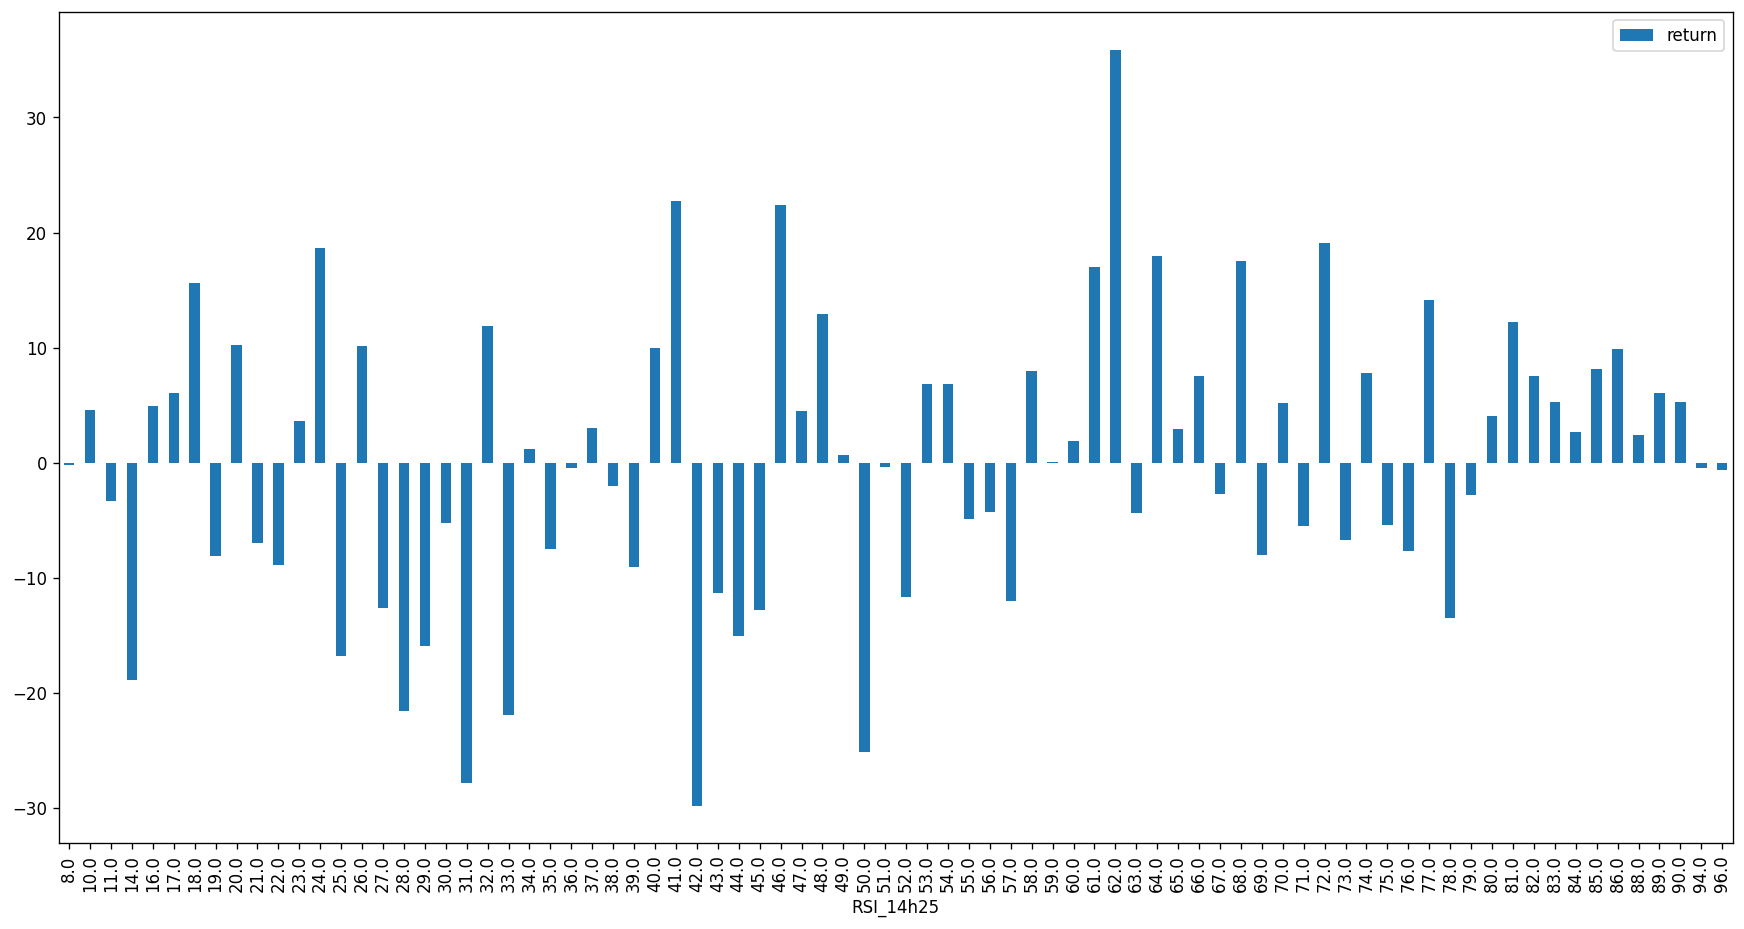

In [35]:
day_data_grouped_by_rsis = analytics_data.groupby(['RSI_14h25'])[['return']].sum()
day_data_grouped_by_rsis.plot.bar()

In [36]:
analytics_data[analytics_data.RSI_14h25 > 57]['return'].sum()

160.79999999999916

In [38]:
analytics_data[analytics_data.RSI_14h25 > 81]['return'].sum()

46.20000000000027

In [37]:
analytics_data[analytics_data.RSI_14h25 < 58]['return'].sum()

-138.00000000000364

## Analytics by morning IBS and afternoon IBS

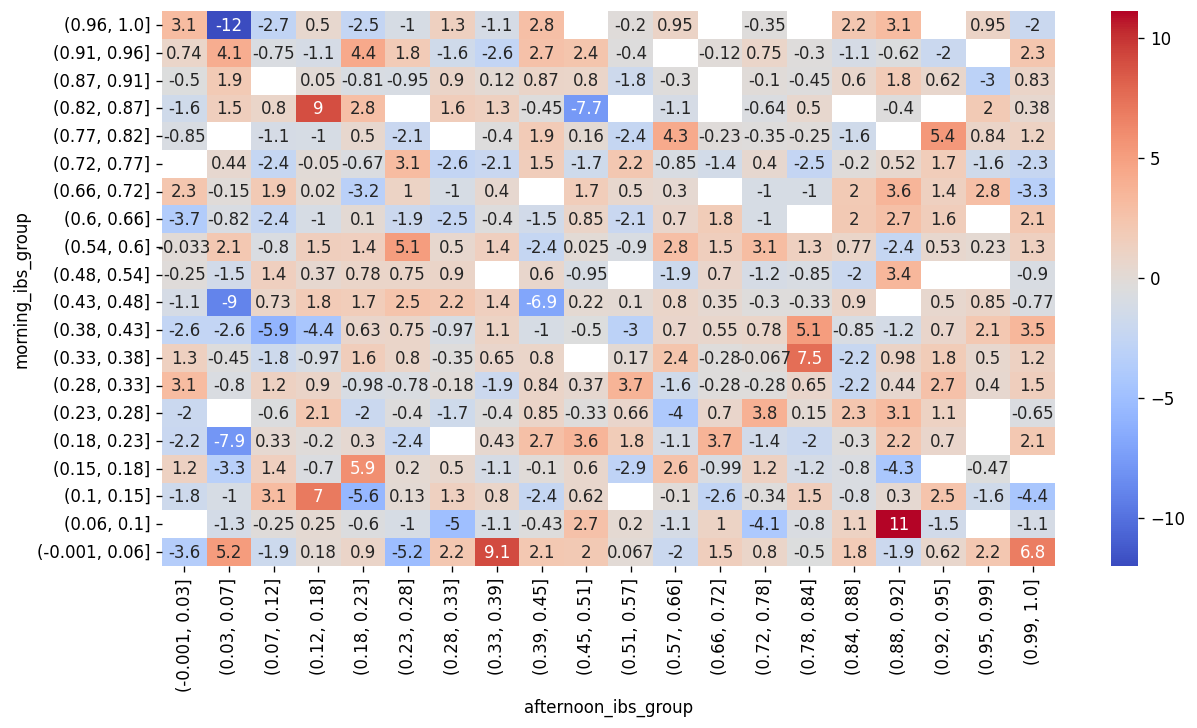

In [19]:
grpd = analytics_data.groupby(['morning_ibs_group', 'afternoon_ibs_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='morning_ibs_group', columns='afternoon_ibs_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

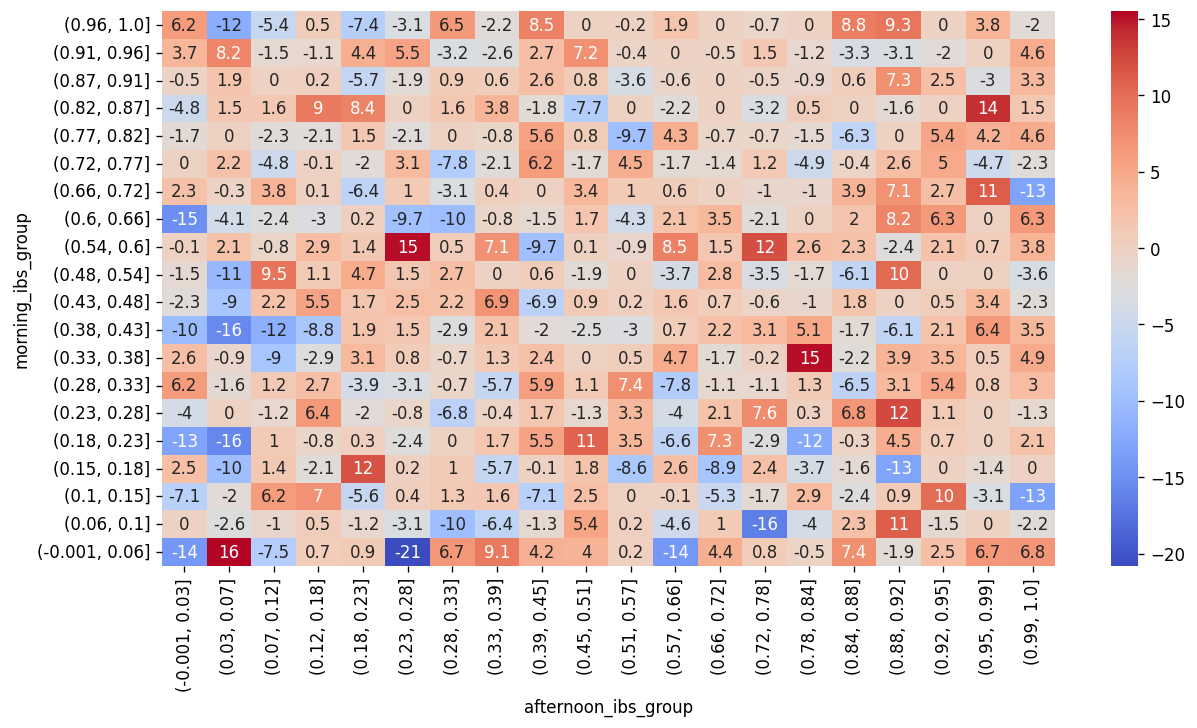

In [20]:
irs_sum = grpd.sum().reset_index()
sns.heatmap(
    irs_sum.pivot(index='morning_ibs_group', columns='afternoon_ibs_group', values='return').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);